# Notes

* Finbert is already pre trained, our goal is to fine tune and test on our dataset


Pre trained Model

* Evaluate not fine tuned pre trained model for (3/5 num classes, 128/256/512 max sequence lenghts) and get metrics

* Fine tune model and compare metrics for (3/5 num classes, 128/256/512 max sequence lenghts) if possible

* Evaluation Metrics:
We returned averaged loss, aggregated true labels and aggregated prediction labels to get the accuracy and confusion matrix

* Techniques
Transfer learning (pretrained on large dataset, fine tuned on smaller one),
Output layer modifications

* Challenges
  
  Very large model so computationaly expensive (need to find tricks to make it work)
  - Divide input into chunks
  - Reducing batch size
  - * RAM issues: use more powerful gpus (nvidia A100), torch empty cache, gradients checkpoints, torch.no_grad() on evaluation.

  
  Bert model have a max lenght of 512. Our dataset (since it's earning calls have an average of 10000+ tokens)
  - Tokenize data using Bert Tokenizer
  - Split Input data in chunks and attribute ID to link them (chunks with same id belong to same input data)
  - Batching has to be modified. All chunks related to the same input data need to be in the same batch.
  - Therefore Batch Size represent number of input data (not chunks) where all chunks of an input data will be in the same batch.
  - In a similar way, Training Validation Testing sets will be determined by input ID.
  - In summary, chunks of an input data will not be spread across set or batches.
  - This data pre-processing explains why batch size is small


  Model was having difficulties learning:
  - Even though I could see different chunks getting different labeling, when we aggregated back (using averaging or most occuring label) the overal language of the transcript (chunks aggregated by id) was always neutral. This could be explained by the fact that earning calls tends to be sugercoated.
  - A solution was to apply further clean up techniques to the transcripts (trimming the text by removing section not related to the transcript [website specific since they were web scrapped], Remove punctuations and urls). This lowered the training and validation loss but there the whole transcript was still getting labeled as positive.
  - Next, we attempted to trim the text by keeping only a percentage of the transcript (attempting to target the ceo and cfo passages). Started by trimming 75, 50, 30% of the transcript. As we increase the percentage, the training and validation loss kept going down but the overall classification was still the same.
  - Since these still did not work, we only focus on the questions and answers section for each dataset.
  - We modify the loss function to included weights such that misclassification of negative and neutral labels will be heavily penalized

  - Extract keywords from the trimmed transcripts and use as input data
  - Since all the data is getting labeled as positive. Use the probability attributed to label 2 as thresholds to determine true sentiment. For example, if probs = [0.2,0.2,0.6] probability for label positive is 0.6. if prob[2] < 0.5, label as negative, else if prob[2] < 0.75 label as neutral, else positive...
  - Try other optimizer functions: RMSprop
  - Try other loss function compatible with multi class classification: hinge loss
  - Increasing learning rate leads to worse losses

  - Best hyper params for lowest loss
  - Change finbert model
  - Use weights until epochs n6
  - Learning Rate Scheduler Step Size = 2, Learning Rate Scheduler Gamma = 1.5. Starting with a very low learning rate and increasing it gradually using a scheduler to mitigate overfitting.


# Set up

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
import sys

optional_dir = "/CS7643Finbert"
#optional_dir = ""


directory = '/content/drive/MyDrive/'+str(optional_dir)

sys.path.append(directory)

%cd '/content/drive/MyDrive/CS7643Finbert'

/content/drive/MyDrive/CS7643Finbert


In [5]:
import torchtext
import torch
import spacy
import tqdm
import numpy
import numpy as np
import jupyter
import notebook
import torch.optim as optim
from transformers import  BertModel, BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
import torch.nn as nn
import os
import re
from torch.utils.data import TensorDataset, random_split, DataLoader, BatchSampler, SequentialSampler
import gc
import pandas as pd
from datetime import datetime, timedelta
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.checkpoint import checkpoint
from collections import Counter


In [6]:
model_name = 'yiyanghkust/finbert-pretrain'

# Process dataset

## Dataset Parameters

In [ ]:
num_classes = 3
max_lenght = 128

very_positive_thres = 7
positive_thres = 3
negative_thres =  -3
very_negative_thres =  -7

## Load Dataset

In [ ]:
# Load FinBERT tokenizer
#tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
tokenizer = BertTokenizer.from_pretrained(model_name)


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
import sqlite3
conn = sqlite3.connect('../transcripts.db')

cursor = conn.cursor()

cursor.execute('SELECT * FROM transcripts')


In [ ]:
data = cursor.fetchall()

In [ ]:
conn.close()

# Get Dataset / Tokenize

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
encoded_inputs = []
encoded_attention_mask = []
text_ids = []
labels = []

for text_id, row in enumerate(data):
  text_original = row[10]
  text_cleaned = text_original
  start_index = re.compile(r"Question\s*-\s*and\s*-\s*Answer\s*Session\s*Operator").search(text_original)
  if start_index is None:
    start_index = re.compile(r"Question\s*-\s*and\s*-\s*Answer\s*Session").search(text_original)
  if start_index is None:

    #print("Error: 'Question-and-Answer' not found in the file."+str(row[3]))
    continue
  end_index = re.compile(r"Read\s+more\s+current").search(text_original)
  if end_index is None:

      #print("Error: 'Read more current' not found in the file. "+str(row[3]))
      continue
  if start_index and end_index :
      # Remove everything before "Question-and-Answer" and after "Read more current"
      text_cleaned = text_original[start_index.start() + len("Question-and-Answer Session Operator"):end_index.start()].strip()

  # Convert to lower case
  text_cleaned = text_cleaned.lower()

  # Remove punctuations
  text_cleaned = text_cleaned.translate(str.maketrans('', '', string.punctuation))
  # Remove urls
  text_cleaned = re.compile(r'https?://\S+|www.\S+').sub('', text_cleaned)

  text_cleaned_no_stopwords = ' '.join([word for word in text_cleaned.split() if word not in stopwords.words('english')])
  text_cleaned_no_stopwords_stemmed = ' '.join([nltk.PorterStemmer().stem(word) for word in text_cleaned_no_stopwords.split()])

  # Specific to Bert models
  # Encode this way because we want to divide into chunks (max lenghts is exceeded here)
  encoded_input = tokenizer.encode_plus(
    #text_cleaned,
    text_cleaned_no_stopwords_stemmed,
    #row[12],
    add_special_tokens=False,  # Add [CLS] and [SEP] tokens
    return_tensors='pt'       # Return PyTorch tensors
    )

  price_movement = ((row[14]-row[15])/row[15])*100

  if num_classes == 3:

    if price_movement < negative_thres:
      label = 0 # negative
    elif price_movement < positive_thres:
      label = 1 # neutral
    else:
      label = 2 # positive

  else:

    if price_movement < very_negative_thres:
      label = 0 # very negative
    elif price_movement < negative_thres:
      label = 1 # negative
    elif price_movement < positive_thres:
      label = 2 # neutral
    elif price_movement < very_positive_thres:
      label = 3 # positive
    else:
      label = 4 # very positive


  # Chunking method inspired from https://towardsdatascience.com/how-to-apply-transformers-to-any-length-of-text-a5601410af7f

  # Get chunks of lenght max_lenght -2 (leaving space for special tokens) for the input data
  input_chunks = encoded_input['input_ids'][0].split(max_lenght-2)
  mask_chunks = encoded_input['attention_mask'][0].split(max_lenght-2)

  processed_input_chunks = []
  processed_mask_chunk = []
  for i in range(len(input_chunks)):

    #add special tokens
    input_chunk = torch.cat([torch.tensor([101]), input_chunks[i], torch.tensor([102])])
    mask_chunk = torch.cat([torch.tensor([1]), mask_chunks[i], torch.tensor([1])])

    # Pad if needed
    pad_len = max_lenght - input_chunk.shape[0]
    # check if tensor length satisfies required chunk size
    if pad_len > 0:
      input_chunk = torch.cat([
          input_chunk, torch.Tensor([0] * pad_len)])
      mask_chunk = torch.cat([
          mask_chunk, torch.Tensor([0] * pad_len)])

    processed_input_chunks.append(input_chunk)
    processed_mask_chunk.append(mask_chunk)

  # Append chunked inputs, masks, ids to group chunks and label to lists
  encoded_inputs.extend(processed_input_chunks)
  encoded_attention_mask.extend(processed_mask_chunk)
  text_ids.extend([text_id] * len(processed_input_chunks))
  labels.extend([label] * len(processed_input_chunks))




In [ ]:
# Convert to tensors
encoded_inputs_pt = torch.stack(encoded_inputs, dim=0)
encoded_attention_mask_pt = torch.stack(encoded_attention_mask, dim=0)
text_ids_pt = torch.tensor(text_ids)
labels_pt = torch.tensor(labels)

In [ ]:
# Define the directory path to save the tensors
save_dir = 'inputTensor/'

# Save encoded inputs and labels to disk
torch.save(encoded_inputs_pt, os.path.join(save_dir, 'encoded_inputs_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))
torch.save(encoded_attention_mask_pt, os.path.join(save_dir, 'encoded_attention_mask_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))
torch.save(text_ids_pt, os.path.join(save_dir, 'text_ids_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))
torch.save(labels_pt, os.path.join(save_dir, 'labels_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))

# Pre Trained Model

## Utils

In [38]:
class FinbertModel(nn.Module):
    def __init__(self, model_name, num_labels=3, device="cpu"):
        super(FinbertModel, self).__init__()
        self.num_labels = num_labels
        self.finbert = BertForSequenceClassification.from_pretrained(model_name)
        self.finbert = self.finbert.to(device)
        self.config = BertConfig(os.path.join(model_name, '/config.json'))
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob).to(device)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels).to(device)
        nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, attention_mask=None):
        pooled_output = self.finbert(input_ids=input_ids,
                                     attention_mask=attention_mask)

        outputs = self.dropout(pooled_output.hidden_states[-1])

        #hidden_states = outputs.hidden_states[-1]
        #dropout_output = torch.nn.functional.dropout(hidden_states, p=0.1, training=model.training)


        logits = self.classifier(outputs)
        return logits

In [39]:
class CustomLoss(nn.Module):
    def __init__(self, weight=None):
        super(CustomLoss, self).__init__()
        self.weight = weight.to("cuda")

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs.to("cuda"), targets.to("cuda"), weight=self.weight).to("cuda")
        return ce_loss


In [40]:
def load_input_tensors(max_lenght, num_classes):
  # Define the directory path to save the tensors
  save_dir = 'inputTensor/'

  # Load the saved tensors from disk
  encoded_inputs_loaded = torch.load(os.path.join(save_dir, 'encoded_inputs_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))
  labels_loaded = torch.load(os.path.join(save_dir, 'labels_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))
  encoded_attention_mask_loaded = torch.load(os.path.join(save_dir, 'encoded_attention_mask_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))
  text_ids_loaded = torch.load(os.path.join(save_dir, 'text_ids_'+str(max_lenght)+"_"+str(num_classes)+'.pt'))

  return encoded_inputs_loaded, labels_loaded, encoded_attention_mask_loaded, text_ids_loaded


def get_model(num_classes, device, model_name):

  model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)

  if num_classes == 5:

    model.classifier = nn.Linear(model.classifier.in_features, 5).to(device)
    model.softmax = nn.Softmax(dim=1).to(device)
  weights = torch.tensor([2.0,2.0, 1.0])
  criterion = CustomLoss(weight=weights).to("cuda")
  #criterion = nn.CrossEntropyLoss().to(device)

  #new_model = ThresholdedModel(model)

  return model, criterion

def hinge_loss(logits, labels):
    """
    Compute Hinge Loss for multi-class classification
    """
    num_classes = logits.size(1)
    correct_scores = logits[torch.arange(logits.size(0)), labels]
    margins = logits - correct_scores.view(-1, 1) + 1.0
    margins[torch.arange(logits.size(0)), labels] = 0.0
    loss = nn.functional.relu(margins).sum() / logits.size(0)
    return loss

def save_training_data(training_data, num_classes,  max_lenght):
  filename = 'outputTensor/training_data+'+str(num_classes)+"_"+str(max_lenght)+'.txt'
  outfile = open(filename, 'w')
  outfile.writelines([str(i)+'\n' for i in training_data])
  outfile.close()

In [41]:
def get_batch_unique_ids(dataset):
    return torch.unique(dataset[:][1])  # Assuming IDs are at index 1

def group_samples_by_ids(dataset, unique_ids):
    grouped_samples = {id_.item(): [[],[],[],[]] for id_ in unique_ids}
    for input, id, label, mask in dataset:
      id_ = id.item()
      grouped_samples[id_][0].extend([input])
      grouped_samples[id_][1].extend([id])
      grouped_samples[id_][2].extend([label])
      grouped_samples[id_][3].extend([mask])
    return grouped_samples

def create_batches(dataset, batch_size=1):

  # Get unique IDs
  unique_ids = get_batch_unique_ids(dataset)
  # Group samples by IDs
  grouped_samples = group_samples_by_ids(dataset, unique_ids)
  # Create batches of unique IDs
  batched_unique_ids = [unique_ids[i:i+BATCH_SIZE] for i in range(0, len(unique_ids), BATCH_SIZE)]
  # For each batch of unique IDs, put all dataset rows that have those unique IDs
  batched_data = {}
  for batch_id, batch_ids in enumerate(batched_unique_ids):
    batched_data[batch_id] = [[],[],[],[]]
    for id_ in batch_ids:
        batched_data[batch_id][0].extend(grouped_samples[id_.item()][0])
        batched_data[batch_id][1].extend(grouped_samples[id_.item()][1])
        batched_data[batch_id][2].extend(grouped_samples[id_.item()][2])
        batched_data[batch_id][3].extend(grouped_samples[id_.item()][3])

  return list(batched_data.values())

def get_aggregated_probabilities(probs, ids, labels):
  input_ids, counts = torch.unique_consecutive(ids, return_counts=True)

  return torch.stack([
      probs[ids == input_id].mean(dim=0)
      for input_id in input_ids
  ]), torch.stack([ labels[ids == input_id].mean(dim=0) for input_id in input_ids])



def get_aggregated_predictions_and_true_labels(probs, ids, labels):
  input_ids, counts = torch.unique_consecutive(ids, return_counts=True)

#most_occurring prediction
#torch.stack([
#     torch.tensor(Counter(probs[ids == input_id].argmax(dim=1)).most_common(1)[0][0])
#      for input_id in input_ids
#  ])


  #Averaged prediction label torch.argmax(torch.stack([ probs[ids == input_id].mean(dim=0) for input_id in input_ids]), dim=1)
  return torch.argmax(torch.stack([ probs[ids == input_id].mean(dim=0) for input_id in input_ids])
  , dim=1) ,torch.stack([ labels[ids == input_id].mean(dim=0) for input_id in input_ids])


def save_output_tensors(all_pred_labels, all_true_labels, all_ids, total_loss, max_lenght, num_classes, model_type):
    # Define the directory path to save the tensors
    out_save_dir = 'outputTensor/'

    # Save encoded inputs and labels to disk
    torch.save(all_pred_labels, os.path.join(out_save_dir, 'pred_labels_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'))
    torch.save(all_true_labels, os.path.join(out_save_dir, 'true_labels_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'))
    torch.save(all_ids, os.path.join(out_save_dir, 'all_ids_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'))
    torch.save(total_loss, os.path.join(out_save_dir, 'total_losses_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'))



In [42]:

# Define functions to filter dataset by text IDs
def filter_dataset_by_text_ids(dataset, text_ids):
    indices = [i for i, text_id in enumerate(dataset.tensors[1]) if text_id in text_ids]
    return torch.utils.data.Subset(dataset, indices)

def get_batches(text_ids_loaded, encoded_inputs_loaded, labels_loaded, encoded_attention_mask_loaded, BATCH_SIZE):

  # Combine all tensors into a single TensorDataset
  text_ids_loaded_converted = text_ids_loaded.long()
  dataset = TensorDataset(encoded_inputs_loaded, text_ids_loaded_converted, labels_loaded, encoded_attention_mask_loaded)

  unique_text_ids = torch.unique(text_ids_loaded_converted)

  # Split text IDs into train, validation, and test sets based on the specified proportions
  train_text_ids, remaining_text_ids = train_test_split(unique_text_ids, train_size=0.7, test_size=0.3, random_state=42)
  val_text_ids, test_text_ids = train_test_split(remaining_text_ids, train_size=0.5, test_size=0.5, random_state=42)


  # Create filtered datasets for train, validation, and test sets
  train_dataset = filter_dataset_by_text_ids(dataset, train_text_ids)
  val_dataset = filter_dataset_by_text_ids(dataset, val_text_ids)
  test_dataset = filter_dataset_by_text_ids(dataset, test_text_ids)

  # Create Batches for train, validation, and test sets
  train_batches = create_batches(train_dataset, batch_size=BATCH_SIZE)
  val_batches = create_batches(val_dataset, batch_size=BATCH_SIZE)
  test_batches = create_batches(test_dataset, batch_size=BATCH_SIZE)

  return train_batches, val_batches, test_batches

  # Create Batches for train, validation, and test sets
  #train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
  #val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
  #test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [43]:
def run_model_testing(model, test_batches, criterion, device):

  model.eval()
  pred_labels = []
  true_labels = []
  all_ids = []
  total_loss = 0.0

  with torch.no_grad():

    for batch in test_batches:

        inputs = torch.stack(batch[0], dim=0).long().to(device)
        ids = torch.stack(batch[1], dim=0).long().to(device)
        labels_float = torch.stack(batch[2], dim=0).float().to(device)
        labels_long = torch.stack(batch[2], dim=0).long().to(device)
        mask = torch.stack(batch[3], dim=0).long().to(device)


        #logits = model(input_ids=inputs, attention_mask=mask)

        outputs = model(input_ids=inputs, attention_mask=mask)

        logits = outputs[0]

        loss = criterion(logits, labels_long)
        #loss = hinge_loss(logits, labels_long)

        probs = torch.nn.functional.softmax(logits, dim=-1)

        #aggreg_probs, aggreg_labels = get_aggregated_probabilities(probs, ids, labels_float)
        #sentiment_labels = model.determine_sentiment(aggreg_probs)

        #preds, aggreg_labels = get_aggregated_predictions_and_true_labels(probs.clone().detach(), ids, labels_float)

        preds = torch.argmax(probs, dim=1)

        pred_labels.extend(torch.split(preds, 1))
        true_labels.extend(torch.split(labels_float, 1))
        all_ids.extend(torch.split(ids,1))
        total_loss += loss.item()

        torch.cuda.empty_cache()
        gc.collect()


  return pred_labels, true_labels, all_ids, torch.tensor([total_loss/len(test_batches)])#, allocated_memory_used, reserved_memory_used

In [44]:
def train_model(num_epochs, model, criterion, train_batches, val_batches, lr_scheduler_step_size, lr_scheduler_gamma, learning_rate, device):
  best_accuracy = 0.0
  #optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
  optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
  #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
  training_data = []

  for epoch in range(num_epochs):
      if epoch == 7:
          criterion = nn.CrossEntropyLoss().to(device)
      model.train()
      total_loss = 0.0

      for batch in train_batches:
          inputs = torch.stack(batch[0], dim=0).long().to(device)
          #ids = torch.stack(batch[1], dim=0).long().to(device)
          labels_long = torch.stack(batch[2], dim=0).long().to(device)
          mask = torch.stack(batch[3], dim=0).long().to(device)

          optimizer.zero_grad()
          outputs = model(input_ids=inputs, attention_mask=mask)
          logits = outputs[0]

          loss = criterion(logits, labels_long)
          #loss = hinge_loss(logits, labels_long)
          loss.backward()

          total_loss += loss.item()

          optimizer.step()

          torch.cuda.empty_cache()
          #break

      # Evaluate the model on validation dataset
      val_pred_labels, val_true_labels, val_ids, val_loss = run_model_testing(model, val_batches, criterion, device)
      val_pred_labels_list = [torch.round(label).item() for label in val_pred_labels]
      val_true_labels_list = [torch.round(label).item() for label in val_true_labels]

      val_accuracy = accuracy_score(val_true_labels_list, val_pred_labels_list)

      if best_accuracy < val_accuracy:
        best_accuracy = val_accuracy
        # Save the best fine-tuned model
        torch.save(model.state_dict(), "finbert_best_fine_tuned.pth")


      average_loss = total_loss / len(train_batches)

      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}, Val Loss: {val_loss.item()}, Val Acc: {val_accuracy}")
      training_data.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}, Val Loss: {val_loss.item()}, Val Acc: {val_accuracy}")
      # Save the fine-tuned model
      torch.save(model.state_dict(), "finbert_fine_tuned.pth")

      # Update learning rate
      #scheduler.step()
  return model, training_data

In [45]:

class ThresholdedModel(nn.Module):
    def __init__(self, model, thresholds_init=[0.21, 0.22, 0.23, 0.24]):
        super(ThresholdedModel, self).__init__()
        self.model = model
        self.num_thresholds = len(thresholds_init) if thresholds_init else 0
        if thresholds_init:
            self.thresholds = nn.Parameter(torch.tensor(thresholds_init, dtype=torch.float32))
        else:
            self.thresholds = nn.Parameter(torch.zeros(self.num_thresholds))

    def forward(self, input_ids=None, attention_mask=None):
        logits = self.model(input_ids=input_ids, attention_mask=attention_mask)[0]
        return logits

    def determine_sentiment(self, logits):
        positive_prob = logits[:, 3]  # Probability for positive label
        thresholds = torch.sigmoid(self.thresholds)  # Apply sigmoid to ensure thresholds are between 0 and 1
        sentiment_labels = torch.where(positive_prob < thresholds[0], torch.tensor(0),
                                        torch.where(positive_prob < thresholds[1], torch.tensor(1),
                                                    torch.where(positive_prob < thresholds[2], torch.tensor(2),
                                                                torch.tensor(3))))
        return sentiment_labels

## Validation/Fine Tuning

### Params

In [46]:
BATCH_SIZE = 8 # keep it low cause it represent input data, not chunks
lr_scheduler_step_size = 2
lr_scheduler_gamma = 1.5
num_epochs = 10
learning_rate = 0.00001


# Don't change unless running on other version of dataset
num_classes = 3 #3or 5
max_lenght = 128 # or 256 or 512
model_type = "fine_tuned"

### Run Model

In [47]:
# Load pre-trained FinBERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, criterion = get_model(num_classes, device, model_name)
# Load input tensors
encoded_inputs_loaded, labels_loaded, encoded_attention_mask_loaded, text_ids_loaded = load_input_tensors(max_lenght, num_classes)
# Get batches
train_batches, val_batches, test_batches = get_batches(text_ids_loaded, encoded_inputs_loaded, labels_loaded, encoded_attention_mask_loaded, BATCH_SIZE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# Fine Tune Model
_, training_data = train_model(num_epochs, model, criterion, train_batches, val_batches, lr_scheduler_step_size, lr_scheduler_gamma, learning_rate, device)



OutOfMemoryError: CUDA out of memory. Tried to allocate 414.00 MiB. GPU 0 has a total capacity of 22.17 GiB of which 116.88 MiB is free. Process 11954 has 22.05 GiB memory in use. Of the allocated memory 21.65 GiB is allocated by PyTorch, and 176.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Save training data to txt
save_training_data(training_data, num_classes, max_lenght)

In [ ]:
# Test Model
all_pred_labels, all_true_labels, all_ids, total_loss = run_model_testing(model, test_batches, criterion, device)


In [ ]:
# Save output tensors
save_output_tensors(all_pred_labels, all_true_labels, all_ids, total_loss, max_lenght, num_classes, model_type)

In [ ]:
test_pred_labels_list = [torch.round(label).item() for label in all_pred_labels]
test_true_labels_list = [torch.round(label).item() for label in all_true_labels]

accuracy_score(test_true_labels_list, test_pred_labels_list)



0.44519940915805023

## Testing

In [13]:
BATCH_SIZE = 8

num_classes = 3
max_lenght = 128

model_type = "not_fine_tuned"

### Run Model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained FinBERT model
model, criterion = get_model(num_classes, device, model_name)
# Load input tensors
encoded_inputs_loaded, labels_loaded, encoded_attention_mask_loaded, text_ids_loaded = load_input_tensors(max_lenght, num_classes)
# Get batches
train_batches, val_batches, test_batches = get_batches(text_ids_loaded, encoded_inputs_loaded, labels_loaded, encoded_attention_mask_loaded, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-pretrain and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Run model
all_pred_labels, all_true_labels, all_ids, total_loss = run_model_testing(model, test_batches, criterion, device)


In [16]:
# Save output tensors
save_output_tensors(all_pred_labels, all_true_labels, all_ids, total_loss, max_lenght, num_classes, model_type)

# Analysis

## Load Tensors

In [7]:
def load_output_tensors(max_lenght, num_classes, model_type):
  # Define the directory path to save the tensors
  out_save_dir = 'outputTensor/'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Load the saved tensors from disk
  pred_labels = torch.load(os.path.join(out_save_dir, 'pred_labels_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'), map_location=torch.device(device))
  true_labels = torch.load(os.path.join(out_save_dir, 'true_labels_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'), map_location=torch.device(device))
  all_ids = torch.load(os.path.join(out_save_dir, 'all_ids_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'), map_location=torch.device(device))
  losses = torch.load(os.path.join(out_save_dir, 'total_losses_'+str(max_lenght)+"_"+str(num_classes)+"_"+str(model_type)+'.pt'), map_location=torch.device(device))
  return pred_labels, true_labels, losses ,all_ids


## Utils

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [1]:
def get_metrics(pred_labels, true_labels, losses, num_classes, model_type):

  # Calculate accuracy
  accuracy = accuracy_score(true_labels, pred_labels)

  # Calculate confusion matrix
  conf_matrix = confusion_matrix(true_labels, pred_labels)

  plot_confusion_matrix(conf_matrix, model_type)

  # Print accuracy and confusion matrix
  print("Accuracy:", accuracy)
  print("Losses:", losses)
  #print("Confusion Matrix:")
  #print(conf_matrix)

  # Generate classification report (includes precision, recall, and F1 score)
  class_report = classification_report(true_labels, pred_labels, zero_division=1, output_dict=True)
  plot_classification_report(class_report, model_type)

  #print("Classification Report:")
  #print(class_report)

  return accuracy


def plot_confusion_matrix(matrix, model_type):
  title = "Confusion Matrix for Finbert Model"
  plt.figure(figsize=(4, 3))
  sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu")
  plt.title(title)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.savefig(title+"_"+model_type+".png")
  plt.show()
  plt.clf()

def plot_classification_report(class_report, model_type):
  title = "Classification Report for Finbert Model"

  # Plot classification report
  plt.figure(figsize=(4, 3))
  sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)
  plt.title(title)
  plt.xlabel('Metrics')
  plt.ylabel('Classes')
  plt.savefig(title+"_"+model_type+".png")
  plt.show()
  plt.clf()


In [12]:
def plot_losses(epochs, train_loss, val_loss, model_type):
  title = "Training vs Validation Loss for Finbert"

  plt.plot(epochs, train_loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(title)
  plt.legend()
  plt.savefig(title+"_"+model_type+".png")
  plt.show()


def get_losses_and_accuracy(max_lenght, num_classes, model_type):
  dir = "outputTensor/" + "training_data+"+str(num_classes)+"_"+str(max_lenght)+".txt"
  with open(dir, 'r') as file:
    lines = file.readlines()
  # Extract data from each line
  epochs = []
  train_loss = []
  val_loss = []
  val_acc = []
  for line in lines:
      parts = line.strip().split(', ')
      epochs.append(int(parts[0].split('/')[0].split(' ')[1]))
      train_loss.append(float(parts[1].split(': ')[1]))
      val_loss.append(float(parts[2].split(': ')[1]))
      val_acc.append(float(parts[3].split(': ')[1]))

  return epochs, train_loss, val_loss, val_acc

def plot_accuracy(epochs, val_acc, model_type):
  title = "Validation Accuracies for Finbert"
  plt.plot(epochs, val_acc, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title(title)
  plt.legend()
  plt.savefig(title+"_"+model_type+".png")
  plt.show()


## Get Metrics Not Fine Tuned

### 3-128

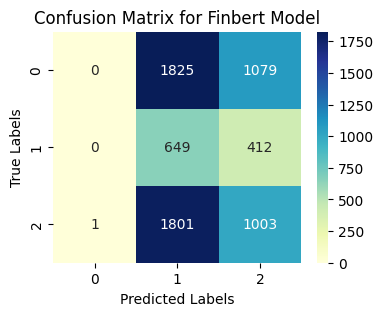

Accuracy: 0.24401772525849336
Losses: tensor([1.1925], device='cuda:0')


<Figure size 640x480 with 0 Axes>

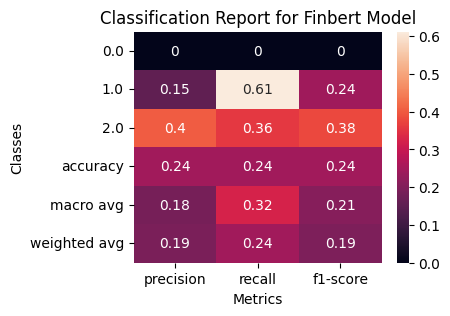

<Figure size 640x480 with 0 Axes>

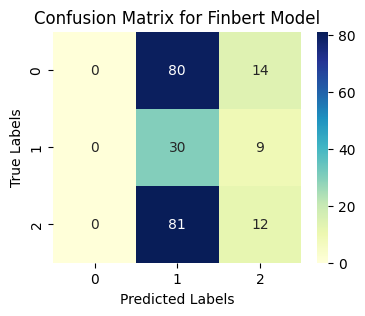

Accuracy: 0.18584070796460178
Losses: tensor([1.1925], device='cuda:0')


<Figure size 640x480 with 0 Axes>

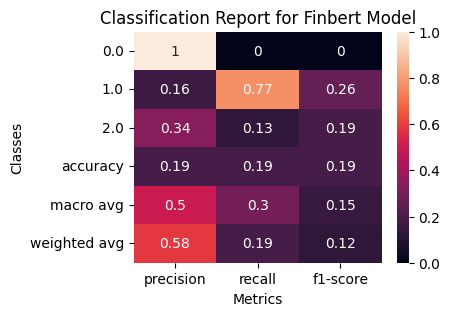

<Figure size 640x480 with 0 Axes>

In [8]:
num_classes = 3
max_lenght = 128
model_type = "not_fine_tuned"

pred_labels, true_labels, losses, all_ids = load_output_tensors(max_lenght, num_classes, model_type)

# Convert lists of tensors to lists of integers
predicted_labels = np.array([label.item() for label in pred_labels])
true_labels = np.array([label.item() for label in true_labels])
all_ids = [int(id.item()) for id in all_ids]


#unaggregated
get_metrics(predicted_labels, true_labels, losses, num_classes, model_type)

#aggregated
input_ids, counts = np.unique(all_ids, return_counts=True)
aggreg_pred = [Counter(predicted_labels[list(np.where(np.array(all_ids) == input_id)[0])]).most_common(1)[0][0]
  for input_id in input_ids
]

aggreg_true = [Counter(true_labels[list(np.where(np.array(all_ids) == input_id)[0])]).most_common(1)[0][0]
  for input_id in input_ids
]

not_fine_tuned_accur = get_metrics(aggreg_pred, aggreg_true, losses, num_classes, model_type)

## Get Metrics Fine Tuned

### 3-128 Weights half

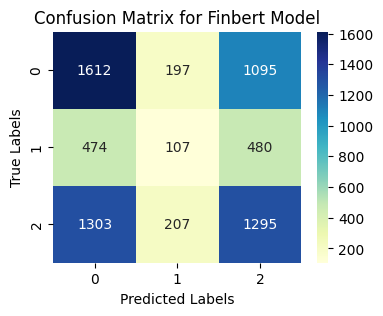

Accuracy: 0.44519940915805023
Losses: tensor([1.5131], device='cuda:0')


<Figure size 640x480 with 0 Axes>

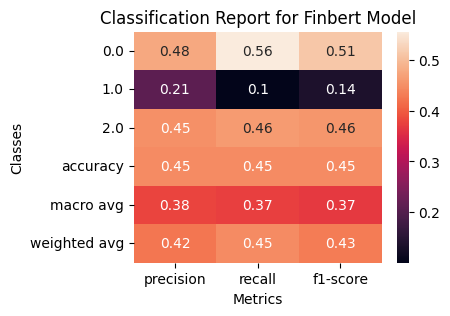

<Figure size 640x480 with 0 Axes>

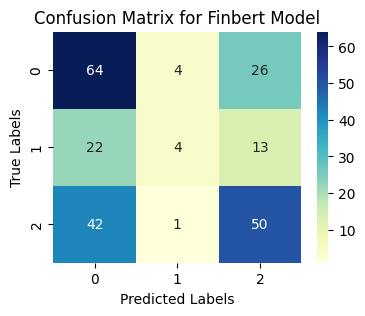

Accuracy: 0.5221238938053098
Losses: tensor([1.5131], device='cuda:0')


<Figure size 640x480 with 0 Axes>

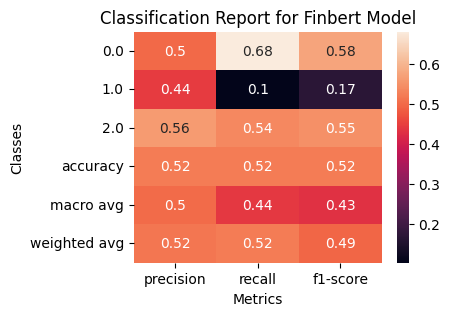

<Figure size 640x480 with 0 Axes>

In [9]:
num_classes = 3
max_lenght = 128
model_type = "fine_tuned"

pred_labels, true_labels, losses, all_ids = load_output_tensors(max_lenght, num_classes, model_type)

# Convert lists of tensors to lists of integers
predicted_labels = np.array([label.item() for label in pred_labels])
true_labels = np.array([label.item() for label in true_labels])
all_ids = [int(id.item()) for id in all_ids]


#unaggregated
get_metrics(predicted_labels, true_labels, losses, num_classes, model_type)

#aggregated
input_ids, counts = np.unique(all_ids, return_counts=True)
aggreg_pred = [Counter(predicted_labels[list(np.where(np.array(all_ids) == input_id)[0])]).most_common(1)[0][0]
  for input_id in input_ids
]

aggreg_true = [Counter(true_labels[list(np.where(np.array(all_ids) == input_id)[0])]).most_common(1)[0][0]
  for input_id in input_ids
]

fine_tuned_accur = get_metrics(aggreg_pred, aggreg_true, losses, num_classes, model_type)


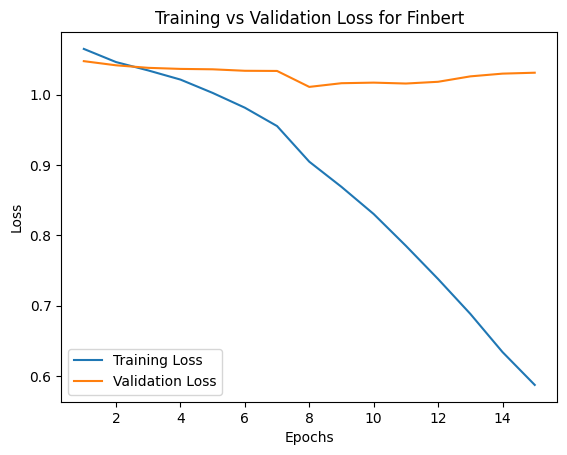

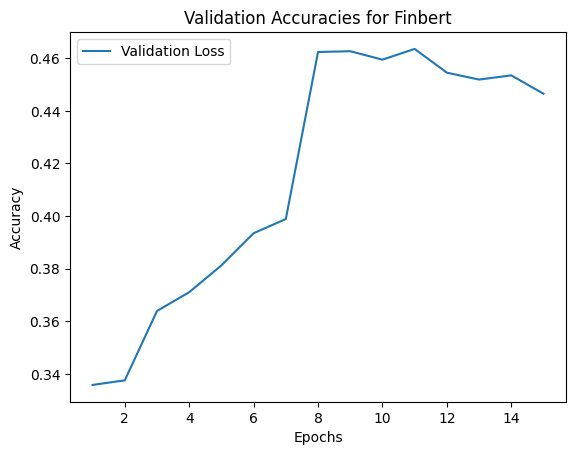

In [16]:
epochs, train_loss, val_loss, val_acc = get_losses_and_accuracy(max_lenght, num_classes, model_type)
plot_losses(epochs, train_loss, val_loss, model_type)
plot_accuracy(epochs, val_acc, model_type)

### Fine Tuned vs Not fined tuned

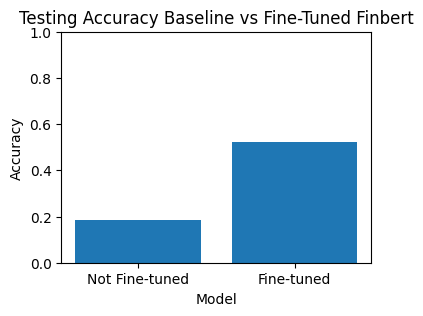

<Figure size 640x480 with 0 Axes>

In [14]:
accuracy = [not_fine_tuned_accur, fine_tuned_accur]
labels = ['Not Fine-tuned', 'Fine-tuned']
title = "Testing Accuracy Baseline vs Fine-Tuned Finbert"

plt.figure(figsize=(4, 3))
# Plotting
plt.bar(labels, accuracy)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title(title)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.savefig(title+".png")
plt.show()
plt.clf()